### Introduction

Systems able to recognize sounds directly from audio recordings are widely applicable. In this project,
you’ll attempt to create an audio tagging system by extracting audio clip image representations and then
using computer vision-based classification models. You can consider constructing your system using a
relatively large-scale competition data set and then evaluate it on its ability to recognize and distinguish more specialized sounds on locally generated recordings.

### Goals

1. Investigate and construct models for automatic audio tagging of noisy recordings.
2. Adapt this to smaller data sets of audio recordings, either by using a setup motivated by your
above findings or by transfer learning.
3. Construct an audio tagging application.

### Methods and materials

To achieve Goal 1 of the project, you can, for example, use the FSDKaggle2018 used in the Freesound
General-Purpose Audio Tagging Challenge on Kaggle. There are 41 categories of audio clips, and the
goal is to classify each clip. For the second objective, you can look for a data set on your own or
construct one yourself.

As part of the project, you should investigate ways to do data augmentation for audio.
You’ll make use of a variety of Python audio libraries, e.g., librosa. You should also look into fastxtend, a library built on top of fastai. To construct the application, you’re free to use any solution you know or want to investigate. A natural starting point is the deployment solutions used in the fastai course.

Consider not converting audio to images but instead setting up an audio classification framework that
operates on audio representations of the data.

## Resources

This is the one I used for the code below. I got stuck trying to tranform the labels from string to numerical values for the GPU to be able to use them with the methods below.
https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5

In [ ]:
from fastai.vision.all import *
import pandas as pd
from pathlib import Path

# Load the labels from the CSV file into a DataFrame
labels_csv_path = '/kaggle/input/audio-samples/FSDKaggle2018.meta/FSDKaggle2018.meta/train_post_competition.csv'
df_labels = pd.read_csv(labels_csv_path)

# Create a dictionary mapping filenames (without extension) to labels
labels_dict = pd.Series(df_labels.label.values, index=df_labels.fname.apply(lambda x: Path(x).stem)).to_dict()

# Define a function to get labels using the dictionary
def get_label(file_path):
    # Extract the filename without extension from the given file path
    file_stem = Path(file_path).stem
    # Return the label from the dictionary
    return labels_dict[file_stem]

In [ ]:
# ----------------------------
# Prepare training data from Metadata file
# ----------------------------
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import LabelEncoder

# Read metadata file
df = pd.read_csv('/kaggle/input/audio-samples/FSDKaggle2018.meta/FSDKaggle2018.meta/train_post_competition.csv')
df.head()

# Take relevant columns
df = df[['fname', 'label']]
df.head()

# Create a table with numerical labels
# Convert labels from strings to numerical labels
label_encoder = LabelEncoder()
numerical_labels = label_encoder.fit_transform(df['label'])
df['label'] = numerical_labels

df.head()

In [ ]:
import math, random
import os
# Added below code for debugging to find the exact line where the error occurs
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

class AudioUtil():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)


 # ----------------------------
  # Convert the given audio to the desired number of channels
  # ----------------------------
    @staticmethod
    def rechannel(aud, new_channel):
        sig, sr = aud

        if (sig.shape[0] == new_channel):
          # Nothing to do
          return aud

        if (new_channel == 1):
          # Convert from stereo to mono by selecting only the first channel
          resig = sig[:1, :]
        else:
          # Convert from mono to stereo by duplicating the first channel
          resig = torch.cat([sig, sig])

        return ((resig, sr))


  # ----------------------------
  # Since Resample applies to a single channel, we resample one channel at a time
  # ----------------------------
    @staticmethod
    def resample(aud, newsr):
        sig, sr = aud

        if (sr == newsr):
          # Nothing to do
          return aud

        num_channels = sig.shape[0]
        # Resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        if (num_channels > 1):
            # Resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])

        return ((resig, newsr))


  # ----------------------------
  # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
  # ----------------------------
    @staticmethod
    def pad_trunc(aud, max_ms):
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr//1000 * max_ms

        if (sig_len > max_len):
          # Truncate the signal to the given length
          sig = sig[:,:max_len]

        elif (sig_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            sig = torch.cat((pad_begin, sig, pad_end), 1)
      
        return (sig, sr)



  # ----------------------------
  # Shifts the signal to the left or right by some percent. Values at the end
  # are 'wrapped around' to the start of the transformed signal.
  # ----------------------------
    @staticmethod
    def time_shift(aud, shift_limit):
        sig,sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)


  # ----------------------------
  # Generate a Spectrogram
  # ----------------------------
    @staticmethod
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig,sr = aud
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)


  # ----------------------------
  # Augment the Spectrogram by masking out some sections of it in both the frequency
  # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
  # overfitting and to help the model generalise better. The masked sections are
  # replaced with the mean value.
  # ----------------------------
    @staticmethod
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
              aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
              aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)
                
        return aug_spec

In [ ]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
    def __init__(self, df, data_path):
        self.df = df
        self.data_path = str(data_path)
        self.duration = 4000
        self.sr = 44100
        self.channel = 2
        self.shift_pct = 0.4
            
  # ----------------------------
  # Number of items in dataset
  # ----------------------------
    def __len__(self):
        return len(self.df)    
    
  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
    def __getitem__(self, idx):
    # Absolute file path of the audio file - concatenate the audio directory with
    # the relative path
        audio_file = self.data_path + "/" + self.df.loc[idx, 'fname']
    # Get the Class ID
        class_id = self.df.loc[idx, 'label']

        aud = AudioUtil.open(audio_file)
    # Some sounds have a higher sample rate, or fewer channels compared to the
    # majority. So make all sounds have the same number of channels and same 
    # sample rate. Unless the sample rate is the same, the pad_trunc will still
    # result in arrays of different lengths, even though the sound duration is
    # the same.
        reaud = AudioUtil.resample(aud, self.sr)
        rechan = AudioUtil.rechannel(reaud, self.channel)

        dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
        shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
        sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
        aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

        return aug_sgram, class_id

In [ ]:
from torch.utils.data import random_split

myds = SoundDS(df, '/kaggle/input/audio-samples/FSDKaggle2018.audio_train/FSDKaggle2018.audio_train')

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

In [ ]:
import torch.nn.functional as F
from torch.nn import init

# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Fourth Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

I presume the error lies in loading the data to the GPU, that the tensors are wrong or something?

In [ ]:
CUDA_LAUNCH_BLOCKING = "1"
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        
        # Get the input features and target labels, and put them on the GPU
        labels = data[1].to(device)
        inputs = data[0].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

  print('Finished Training')


# CUDA error: device-side assert triggered - For debugging consider passing CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
  
num_epochs=2   # Just for demo, adjust this higher.
training(myModel, train_dl, num_epochs)

# Old code below

In [1]:
from fastai.vision.all import *
import pandas as pd
from pathlib import Path

# Define a function to get labels
def get_label_from_filename(fname):
    # Split the filename on underscores
    parts = Path(fname).stem.split('_')
    # Take all but the last part as the label, and rejoin with underscores
    label = ' '.join(parts[:-1])
    return label

In [2]:
# Define DataBlock
spectrogram_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_label_from_filename,
    item_tfms=Resize((400, 1000))
)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 66.3MB/s]


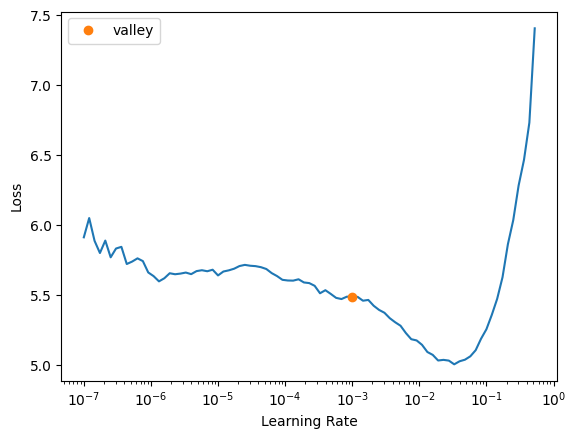

In [3]:
# Point to the path where train images are stored
path = Path('/kaggle/input/melspecs/Spectograms')

# Create the DataLoaders
dls = spectrogram_block.dataloaders(path, bs=16)

# Create a learner with a pre-trained model
learn = vision_learner(dls, resnet34, metrics=accuracy)

# Find an appropriate learning rate
learning_rate = learn.lr_find()

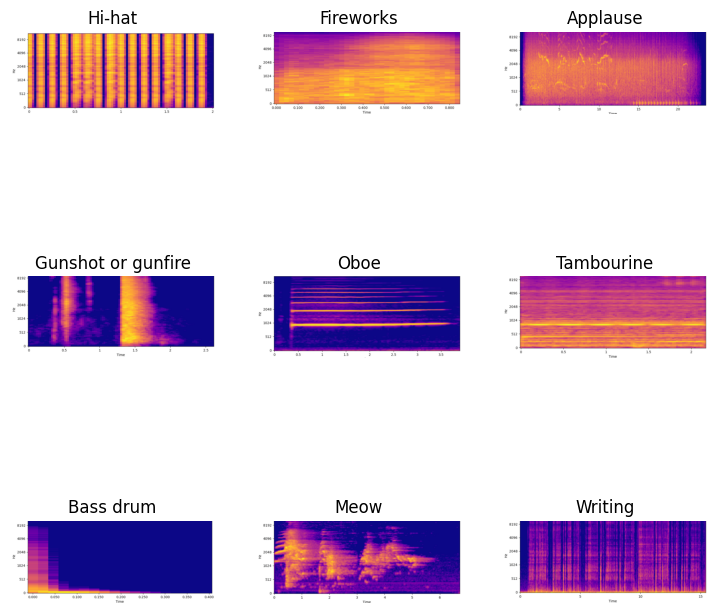

In [4]:
dls.show_batch()

In [5]:
# Train the model
learn.fit_one_cycle(5, learning_rate)

epoch,train_loss,valid_loss,accuracy,time
0,2.908864,1.877098,0.491024,02:06
1,1.973233,1.329235,0.620380,02:06
2,1.522982,1.083435,0.694826,02:07
3,1.213103,0.958493,0.732313,02:07
4,1.090967,0.947105,0.730201,02:06


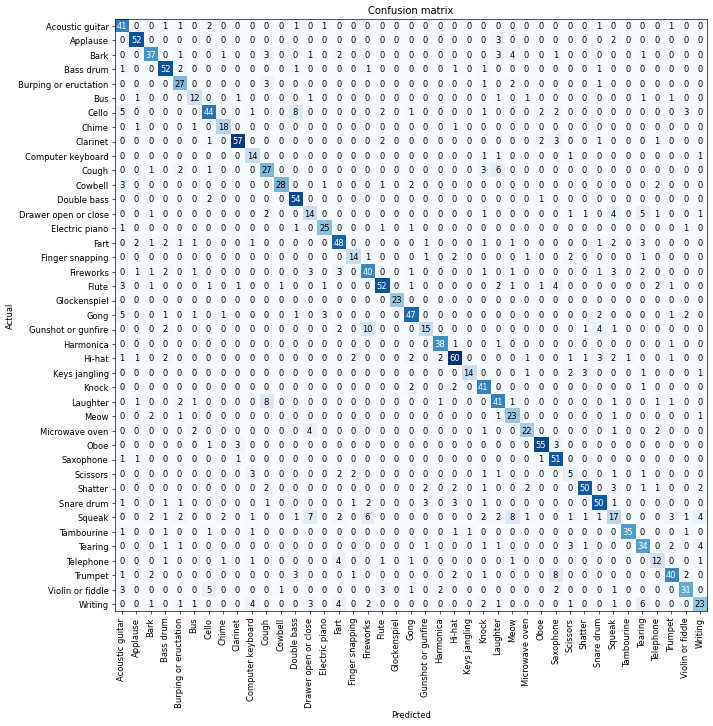

In [6]:
# Create an interpretation object
interp = ClassificationInterpretation.from_learner(learn)

# Plot the confusion matrix
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

In [7]:
# Export the model - this will create an 'export.pkl' file
learn.export('/kaggle/working/sound_prediction.pkl')

# Make a prediction on a sound recording

In [ ]:
# Types of sounds that can be recorded: Applause, burp, computer keyboard, cough, drawer open or close, fart, 
# finger snapping, keys jangling, knock, laughter, microwave oven, scissors, squeak, tearing, telephone, writing